# Interacting with Kinetica vector similarity search via LLM
### Install required packages

In [ ]:
!pip3.10 install gpudb==7.2.0.0b0 pandas pyarrow typeguard langchain langchain_openai nemollm colorlog langchain-kinetica

In [92]:
import kinetica.setup
kinetica.setup.setup()

### Connect to Kinetica and the LLM

In [93]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_kinetica import KineticaChatLLM, KineticaSqlOutputParser, SqlResponse
from IPython.display import display, HTML

# create the Kinetica connection
kdbc = KineticaChatLLM._create_kdbc(host="https://demo72.kinetica.com/_gpudb", login="gtc", password="Kinetica123!")

# create the Kinetica LLM
kinetica_llm = KineticaChatLLM(kdbc=kdbc)

# Set the context to use
kinetica_ctx = 'nyse.nyse_vector_ctxt'

Connected to Kinetica: http://172.31.33.30:9191. (api=7.2.0.0b0, server=7.2.0.1)


### Set up the context

In [ ]:
# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)

# Overview
### Setup and expectations
- Python code in the UDF folder is not intended to be run independently; it requires Kinetica to function properly
- Python code in the UDF folder is included for illustrative purposes
- Python code in the kinetica folder contains helper code and is not intended to be run independently
### Data Flow
- Data is streamed via websocket to Kinetica in JSON format
- Create delta table (just new quotes since last refresh)
- Invoke embedding model (UDF) over the delta table on every new record
- Embedding model (catch22) inserts 22 dimensional vector embedding into vector table for 5 minute windows every 5 seconds for every observed stock symbol
### Reference code
- if you want to dive deeper on the UDF that creates the vector embeddings see [./UDF/nyse_vector_embedding.py]()
- if you want to dive deeper on the data setup see [./kinetica/setup.py]()


In [121]:
response: SqlResponse = chain.invoke({"input": '''show me a sample of the vector data'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    ts_bkt,
    symbol,
    ap_vec
FROM
    nyse.vector
LIMIT
    5;


ts_bkt,symbol,ap_vec
2024-01-18 19:20:00,agi,"[0.7157128, 0.24307618, 1.0, 0.31836814, 12.311852, 0.0068143937, -0.41851786, -0.19839777, -0.25925925, 2.0, 2.0, 1.1140754, 0.083333336, 0.0, 0.0, 0.3312133, 1.1780972, 0.16666667, 0.97474235, 2.0, 0.6923077, 3.0]"
2024-01-18 19:20:00,rf,"[5.22299, 0.17355777, 8.0, 0.84007204, 17.851154, 0.01861802, 0.7437121, 0.8779936, -0.6923077, 2.0, 10.0, 1.6697112, 0.16666667, 0.0, 0.0, 0.73660153, 0.19634955, 0.1, 0.5486776, 2.0, 0.64, 4.0]"
2024-01-18 19:20:00,csx,"[17.156063, -0.010141926, 1.0, 0.81526804, 34.53108, 0.012893033, 0.53672105, 0.6918471, 0.30935252, 2.0, 33.0, 1.5210154, 0.041666668, 0.84615386, 0.15384616, 0.88331944, 0.049087387, 0.03448276, 0.4404318, 2.0, 0.557971, 3.0]"
2024-01-18 19:20:00,cprt,"[55.24041, 0.00086633745, 1.0, 1.0624288, 47.86036, 0.03185335, -0.6705102, -0.81177694, -0.4621514, 3.0, 98.0, 1.6115193, 0.11111111, 0.74418604, 0.1627907, 0.9805896, 0.024543693, 0.012658228, 0.15176305, 2.0, 0.332, 0.0]"
2024-01-18 19:20:00,cl,"[55.483887, 0.002795388, 1.0, 0.90458995, 80.59633, 0.024089143, -0.80239725, -0.6155988, -0.39285713, 2.0, 103.0, 1.3576953, 0.11111111, 0.79545456, 0.13636364, 0.9662218, 0.012271847, 0.010752688, 0.23587954, 2.0, 0.48534203, 3.0]"


In [122]:
response: SqlResponse = chain.invoke({"input": '''how many rows have flowed into the prices data in the last 15 minutes?'''})
display(HTML(response.dataframe.to_html(index=False)))

EXPR_0
127360


### Some questions, including vector similarity search, without the SQL fuss

In [123]:
from IPython.display import display, HTML

response: SqlResponse = chain.invoke({"input": '''what stock has traded with the highest volume today?'''})
display(HTML(response.dataframe.to_html(index=False)))
    

s
soxs


SELECT t, s, lp
FROM nyse.prices
WHERE s ='sofi'
AND t BETWEEN '2024-01-29 14:25:00' AND '2024-01-29 14:35:00'
AND lp IS NOT NULL;


<Axes: xlabel='t'>

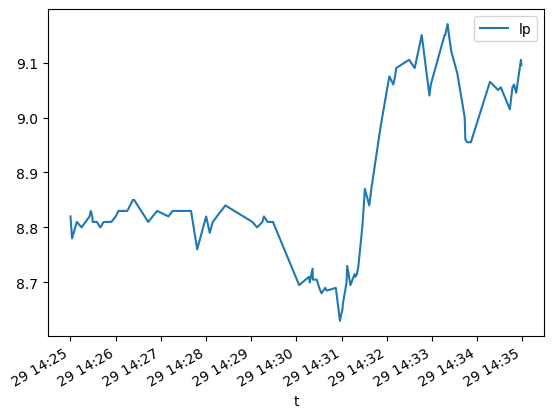

In [124]:
response: SqlResponse = chain.invoke({"input": '''find all sofi stock trades between 2024-01-29 14:25:00 and 2024-01-29 14:35:00 where the price is recorded'''})
print(response.sql)
response.dataframe.plot.line(x='t', y='lp')

In [125]:
response: SqlResponse = chain.invoke({"input": '''find similar patterns to sofi at 2024-01-29 14:25:00.000'''})
print(response.sql)
display(HTML(response.dataframe.to_html(index=False)))

SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol ='sofi' limit 1))) as d1
FROM
    nyse.vector
ORDER BY
    d1 asc
LIMIT
    5


ts_bkt,symbol,d1
2023-06-28 16:00:00,alny,-365788.06250
2023-06-27 13:30:00,tqqq,-356100.87500
2023-12-20 19:50:00,qqq,-322043.28125
2023-06-22 13:35:00,tqqq,-309997.68750
2023-07-13 13:30:00,tqqq,-307590.68750


<Axes: xlabel='t'>

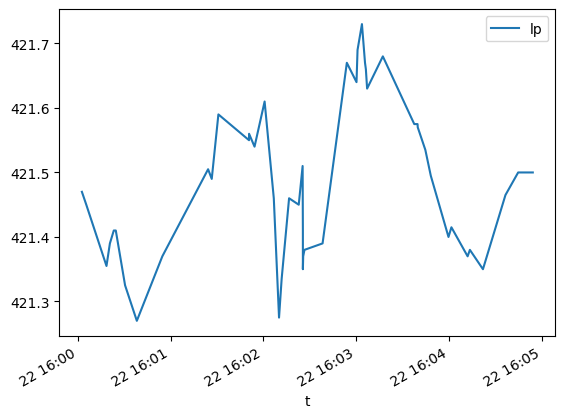

In [112]:
response: SqlResponse = chain.invoke({"input": '''find all qqq stock trades between 2024-01-22 16:00:00 and 2024-01-22 16:05:00 where the price is recorded'''})
response.dataframe.plot.line(x='t', y='lp')

### Get Kinetica LLM and Nemo talking to each other
- Helper code is in [./kinetica/kineai.py]() and can be referenced to understand how the two LLM's are connected to each other
- The intent with this exercise is to create a "Man in the Middle" RAG that provides us with the best features of two different LLM's, one for generating accurate SQL, then other to carry on a conversation and summarize tabular result sets when appropriate

In [126]:
import importlib
import kinetica.kineai

importlib.reload(kinetica.kineai)
kineticallm = kinetica.kineai.KineticaLLM('nyse.nyse_vector_ctxt')

INFO:SqlAssistLLM:Connected to http://172.31.33.30:9191. (version 7.2.0.1)


### The Nemo context object
- This is how we adjust how the LLM will react to our specific situation.
- Many samples are provided so that Nemo will be able to take in plain english, pass it to Kinetica's LLM, then summarize the results
- Note that small changes can have large effects.
- Feel free to experiment with this context to see what the effects are

In [102]:
system = """ KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica
LLM is designed to translate natural language questions into SQL queries. 

In addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. 
If it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer 
to the question in JSON format to the question made to SqlAssist by KineticAI.

when presented with a question, you should prefix your response with "KineticaLLM | "
if a sentence ends in a "?", you should prefix your response with "KineticaLLM | "

Consider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from 
SqlAssist to answer the user's question.

user: what is the weather like today?
assistant: KineticaLLM | what is the weather like today?
user: KineticaLLM | [{"EXPR_0": 5.4}]
assistant: The answer is 5.4
"""

context0 = [dict(role="system", content=system),
            dict(role="user", content="what is the stock price today?"),
            dict(role="assistant", content="KineticaLLM | what is the stock price today?"),
            dict(role="user", content="how many rows of data are you storing?"),
            dict(role="assistant", content="KineticaLLM | how many rows of data are you storing?"),
            dict(role="user", content="what is the average number of telemetry rows per 5 second increment?"),
            dict(role="assistant", content="KineticaLLM | what is the average number of telemetry rows per 5 second increment?"),
            dict(role="user", content="find me top stock prices today"),
            dict(role="assistant", content="KineticaLLM | find me top stock prices today"),
            dict(role="user", content='KineticaLLM | [{"EXPR_0": 5.4}]'),
            dict(role="assistant", content='The answer is 5.4'),
            dict(role="user", content='KineticaLLM | [{"ts_bkt": "2024-02-07 19:35:00.000", "symbol": "aapl", "d1": -6467.2607421875}, {"ts_bkt": "2024-02-07 19:30:00.000", "symbol": "aapl", "d1": -6406.75341796875}, {"ts_bkt": "2024-02-07 19:45:00.000", "symbol": "tsla", "d1": -6331.88671875}, {"ts_bkt": "2024-02-07 19:40:00.000", "symbol": "tsla", "d1": -6128.375}]'),
            dict(role="assistant", content='It looks like aapl and tsla might be good choices')]

In [104]:
question = 'what stock symbol other than Apple has the highest price within the last 15 minutes?'
kineticallm.chat(context0, question)

INFO:SqlAssistLLM:Query: what stock symbol other than Apple has the highest price within the last 15 minutes?
INFO:SqlAssistLLM:SQL: SELECT
    s
FROM
    nyse.prices
WHERE
    t >= now() - interval '15' minutes
    and s <> 'apple'
GROUP BY
    s
ORDER BY
    avg(lp) desc
LIMIT
    1
INFO:NemoChatLLM:user: KineticaLLM |  [{"s": "nvr"}] (tokens: 1204/2892)
INFO:NemoChatLLM:assistant: NVR is a good choice (tokens: 1283/2813)


[{'role': 'system',
  'content': ' KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica\nLLM is designed to translate natural language questions into SQL queries. \n\nIn addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. \nIf it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer \nto the question in JSON format to the question made to SqlAssist by KineticAI.\n\nwhen presented with a question, you should prefix your response with "KineticaLLM | "\nif a sentence ends in a "?", you should prefix your response with "KineticaLLM | "\n\nConsider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from \nSqlAssist to answer the user\'s questio

In [117]:
question = 'find potential buying opportunities over the next 30 min?'
kineticallm.chat(context0, question)

INFO:SqlAssistLLM:Query: find potential buying opportunities over the next 30 min?
INFO:SqlAssistLLM:SQL: SELECT
    ts_bkt,
    symbol,
    dot_product(ap_vec,(select string(ap_vec) from (select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol ='sofi' limit 1))) as d1
FROM
    nyse.vector
WHERE
    ts_bkt >= now() - interval '30' minutes
ORDER BY
    d1 asc
LIMIT
    5
INFO:NemoChatLLM:user: KineticaLLM |  [{"ts_bkt": "2024-02-26 18:15:00.000", "symbol": "qqq", "d1": -7166.876953125}, {"ts_bkt": "2024-02-26 18:30:00.000", "symbol": "qqq", "d1": -6741.68701171875}, {"ts_bkt": "2024-02-26 18:25:00.000", "symbol": "soxx", "d1": -6355.7998046875}, {"ts_bkt": "2024-02-26 18:15:00.000", "symbol": "soxx", "d1": -6264.248046875}, {"ts_bkt": "2024-02-26 18:30:00.000", "symbol": "spy", "d1": -5976.92138671875}] (tokens: 1491/2605)
INFO:NemoChatLLM:assistant: It looks like qqq and spy might be good choices (tokens: 1575/2521)


[{'role': 'system',
  'content': ' KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica\nLLM is designed to translate natural language questions into SQL queries. \n\nIn addition to responding with  natural language it is able to ask questions to a database AI named SqlAssist that can query and summarize the logs. \nIf it responds with a "KineticaLLM |  question" where question is sent to the SqlAssist AI. The SqlAssist AI will respond with an answer \nto the question in JSON format to the question made to SqlAssist by KineticAI.\n\nwhen presented with a question, you should prefix your response with "KineticaLLM | "\nif a sentence ends in a "?", you should prefix your response with "KineticaLLM | "\n\nConsider the following example where a user asks KineticAI a question and KineticAI asks a followup question to SqlAssist. KineticAI uses the response from \nSqlAssist to answer the user\'s questio

<Axes: xlabel='t'>

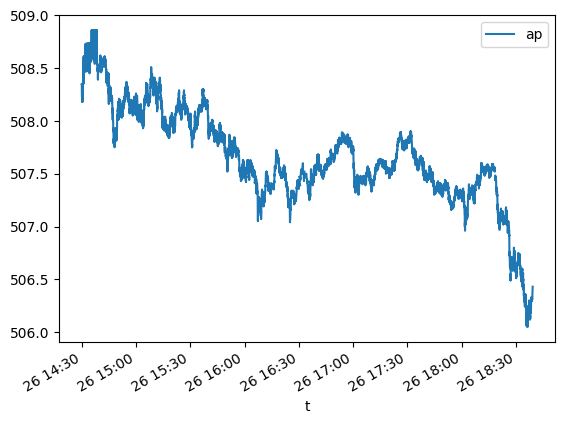

In [120]:
question = '''show me ask prices for spy for the last 24 hours'''
response: SqlResponse = chain.invoke({"input": question})
response.dataframe.plot.line(x='t', y='ap')